In [ ]:
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="admin",
    database="granddebattest"
)

cursor = db.cursor(dictionary=True)

In [ ]:
cursor.execute("""
SELECT th.nom_Theme, arg.texte, arg.type 
FROM `contribution` AS contr JOIN `arguments` AS arg USING(id_contrib) JOIN `theme` AS th ON contr.FK_theme_id = th.id_theme
""")

In [ ]:
arguments = cursor.fetchall()

In [ ]:
arguments = pd.DataFrame(arguments, columns=arguments[0].keys())

In [ ]:
arguments.to_csv("data/argumentsVD.csv", index=None, header=True)

In [2]:
import pandas as pd
import os
import string
from collections import Counter
from time import time
import numpy as np
import itertools
from pandarallel import pandarallel
import matplotlib.pyplot as plt

In [3]:
from textblob import TextBlob
import nltk
from nltk import word_tokenize
from nltk.util import ngrams

In [ ]:
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [4]:
import spacy
nlp = spacy.load("fr_core_news_sm")

In [5]:
seed = 1

In [6]:
dates_GDN = ["31-01-19","06-02-19","17-02-19","02-03-19","08-03-19","21-03-19"]
sujets_GDN = {"ecologie": "LA_TRANSITION_ECOLOGIQUE",
             "democratie": "DEMOCRATIE_ET_CITOYENNETE",
             "fisc": "LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES",
             "etat": "ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS"}
sujets_VD = os.listdir("data/VD")

In [7]:
#flatten = lambda l: [item for sublist in l for item in sublist]

In [8]:
#-> Plus efficace
flatten = lambda l: list(itertools.chain(*l))

In [9]:
filter_flatten_tags = lambda docs: [t for tokens in docs for t in tokens if not (t.is_punct or t.is_space or t.is_stop)]

In [10]:
pd.set_option("display.max_columns",70)

--------------------

---------

In [29]:
df = pd.read_csv("data/VDFull.csv")

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,11,12,13,34,35,36,42,43,46,47,50,51,54,55,56,57,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
df

,type,contributions_id,contributions_author_id,contributions_section_title,contributions_title,contributions_bodyText,contributions_createdAt,contributions_updatedAt,contributions_url,contributions_published,contributions_trashed,contributions_trashedStatus,contributions_trashedAt,contributions_trashedReason,contributions_votesCount,contributions_votesCountOk,contributions_votesCountMitige,contributions_votesCountNok,contributions_argumentsCount,contributions_argumentsCountFor,contributions_argumentsCountAgainst,contributions_sourcesCount,contributions_versionsCount,contributions_arguments_related_id,contributions_arguments_related_kind,contributions_arguments_id,contributions_arguments_author_id,contributions_arguments_type,contributions_arguments_body,contributions_arguments_createdAt,contributions_arguments_updatedAt,contributions_arguments_url,contributions_arguments_published,contributions_arguments_trashed,contributions_arguments_trashedStatus,contributions_arguments_trashedAt,contributions_arguments_trashedReason,contributions_arguments_votesCount,contributions_votes_id,contributions_votes_author_id,contributions_votes_value,contributions_votes_createdAt,contributions_reportings_related_id,contributions_reportings_related_kind,contributions_reportings_id,contributions_reportings_author_id,contributions_reportings_type,contributions_reportings_body,contributions_reportings_createdAt,contributions_sources_id,contributions_sources_related_id,contributions_sources_related_kind,contributions_sources_author_id,contributions_sources_trashed,contributions_sources_trashedStatus,contributions_sources_trashedAt,contributions_sources_trashedReason,contributions_sources_body,contributions_sources_createdAt,contributions_sources_updatedAt,contributions_sources_published,contributions_sources_votesCount,contribution_versions_id,contribution_versions_title,contribution_versions_bodyText,contribution_versions_createdAt,contribution_versions_updatedAt
0,opinion,2a6dce90-3c3a-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,"Justice, Police, Armée",Fin de la dissuasion nucléaire,Mettre plutôt nos investissements dans les out...,2019-03-01 16:53:32,NaN,https://le-vrai-debat.fr/consultations/justice...,Yes,No,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2a6dce90-3c3a-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,NaN,NaN,2019-03-01 16:53:32,NaN,https://le-vrai-debat.fr/consultations/justice...,Yes,No,NaN,NaN,NaN,1.0,2a6dce90-3c3a-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,NaN,2019-03-01 16:53:32,NaN,NaN,2a6dce90-3c3a-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,NaN,NaN,2019-03-01 16:53:32,2a6dce90-3c3a-11e9-988a-fa163e5b3bfd,NaN,NaN,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,No,NaN,NaN,NaN,NaN,2019-03-01 16:53:32,NaN,Yes,1.0,2a6dce90-3c3a-11e9-988a-fa163e5b3bfd,Fin de la dissuasion nucléaire,Mettre plutôt nos investissements dans les out...,2019-03-01 16:53:32,NaN
1,vote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T3BpbmlvblZvdGU6MTE3MzA1NQ==,NaN,YES,2019-03-01 16:53:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,opinion,d2a3afbb-3c39-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,"Justice, Police, Armée",Retour des forces militaires françaises engagé...,Mettre fin à une politique militaire d'ingéren...,2019-03-01 16:51:05,NaN,https://le-vrai-debat.fr/consultations/justice...,Yes,No,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,d2a3afbb-3c39-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,NaN,NaN,2019-03-01 16:51:05,NaN,https://le-vrai-debat.fr/consultations/justice...,Yes,No,NaN,NaN,NaN,1.0,d2a3afbb-3c39-11e9-988a-fa163e5b3bfd,VXNlcjo3MzIwNTEwZi0zYzBlLTExZTktOTg4YS1mYTE2M2...,NaN,2019-03-01 16:51:

## STATS VD

In [11]:
stats = pd.DataFrame()

In [12]:
participations_total = 0
opinions_total = 0
arguments_total = 0

for sujet in sujets_VD:
    df = pd.read_csv(f"data/VD/{sujet}")
    
    sujet_name = df["contributions_section_title"].dropna().unique()[0]
    nb_opinions = df[df.type == 'opinion'].shape[0]
    nb_arguments = df[df.type == 'argument'].shape[0]
    nb_propositions = df[(df.type == 'opinion') | (df.type == 'argument')].shape[0]
    
    #print(f"Sujet: {sujet_name}")
    #print(f"Nb contributions: {nb_propositions}")
    #print(f"Opinions: {nb_opinions}  |  Arguments: {nb_arguments}")
    #print(f"="*40)
    
    stats[sujet_name] = [nb_opinions, nb_arguments, nb_propositions]
    
    participations_total += nb_propositions
    opinions_total += nb_opinions
    arguments_total += nb_arguments
    
stats = stats.transpose()
#print(f"Nb total participations: {participations_total}")
#print(f"Nb total opinions: {opinions_total}")
#print(f"Nb total arguments: {arguments_total}")

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,11,12,13,34,35,36,42,43,46,47,50,51,54,55,56,57,59,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,34,35,36,39,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,11,12,34,35,42,43,46,47,50,51,54,55,57,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Col

In [13]:
stats.columns = ["nb_opinions","nb_arguments","nb_contributions"]

In [14]:
stats["perc_arguments"] = round(stats["nb_arguments"]/stats["nb_contributions"],2)

In [15]:
stats

,nb_opinions,nb_arguments,nb_contributions,perc_arguments
"Justice, Police, Armée",1400,2828,4228,0.67
Expression Libre & Sujets de société,3769,19204,22973,0.84
"Démocratie, Institutions",4062,15387,19449,0.79
"Transition Ecologique et Solidaire, Agriculture & Alimentation, Transport",2599,3775,6374,0.59
"Europe, Affaires Etrangères, Outre-mer",963,4822,5785,0.83
Sport / Culture,593,2810,3403,0.83
"Education, jeunesse, Enseignement Supérieur, Recherche et Innovation",1581,6455,8036,0.80
"Economie, Finances, Travail, Compte public",6409,17313,23722,0.73
"Santé, Solidarité, Handicap",1900,4126,6026,0.68


In [ ]:
df

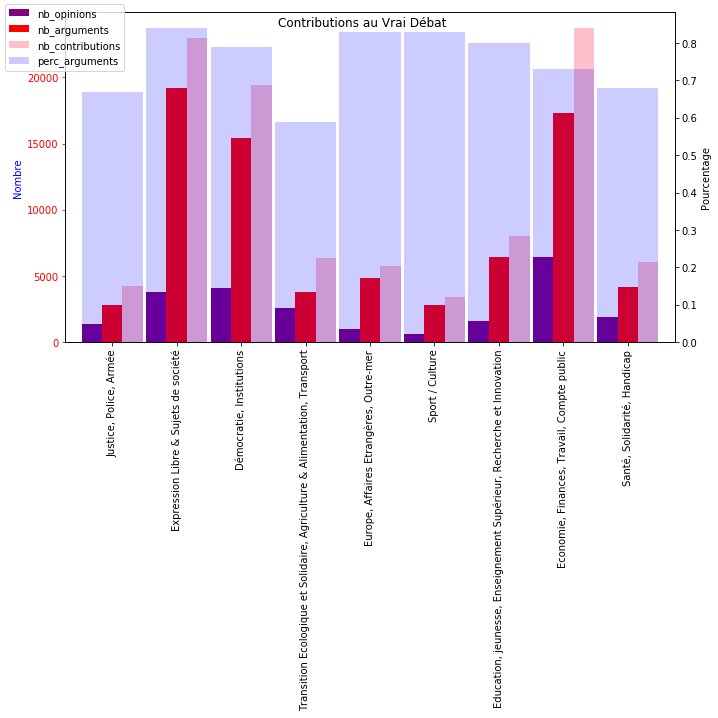

In [28]:
fig, VDcontrib = plt.subplots(figsize=(10, 10))
VDcontrib.set_ylabel("Nombre")


stats[stats.columns[:-1]].plot.bar(color=["purple","red","pink"], width=0.95, legend=False, ax=VDcontrib)

VDperc = VDcontrib.twinx()
VDperc.set_ylabel("Pourcentage")

stats.plot.bar(y='perc_arguments',color=["blue"], alpha=0.2, width=0.95, legend=False, ax=VDperc)
#VDcontrig.set_title("Nombre de contributions")
VDcontrib.tick_params(axis='y', colors='red')
VDcontrib.yaxis.label.set_color('blue')

fig.tight_layout()
fig.legend(loc='upper left')
fig.suptitle("Contributions au Vrai Débat")
fig.savefig("data/VDStats.png", bbox_inches='tight')

In [ ]:
df = pd.read_csv("data/VDFull.csv")

In [ ]:
df["contributions_section_title"].dropna().unique()

In [ ]:
df

______________________________

In [ ]:
def create_pos_dict(posList):
    pos_dict = dict()
    for lemma, tag in posList:
        pos_dict.setdefault(tag, []).append(lemma)
    return pos_dict

In [ ]:
def create_counter_dict(pos_data):
    pos_counters = dict()
    for pos in pos_data:
        pos_counters[pos] = Counter(pos_data[pos])
    return pos_counters

In [ ]:
def dsp_most_common_pos(dict_counters, n):
    for tag in dict_counters:
        print(f'Les {n} {spacy.explain(tag)} les plus fréquents :')
        for mot in dict_counters[tag].most_common(n):
            print(mot)
        print("="*40)

In [ ]:
def pos_to_df(posList, n):
    pos_dict = create_pos_dict(posList)
    pos_counters = create_counter_dict(pos_dict)
    return get_most_common(pos_counters, n)

In [ ]:
def get_most_common(dict_counters, n):
    for tag in dict_counters:
        most_common = dict_counters[tag].most_common(n)
        if len(most_common) < n:
            most_common += [np.nan]*(n-len(most_common))
        dict_counters[tag] = most_common
    return pd.DataFrame(dict_counters)

In [ ]:
def show_most_common(posList, n):
    pos_dict = create_pos_dict(posList)
    pos_counters = create_counter_dict(pos_dict)
    dsp_most_common_pos(pos_counters, n)

Faire le pourcentage d'arguments positifs et négatifs par thème pourrait être pas mal

In [ ]:
opinions = df[df.type == 'opinion'].reset_index(drop=True)
arguments = df[df.type == 'argument'].reset_index(drop=True)

In [ ]:
opinions = opinions["contributions_bodyText"]
arguments = arguments[["contributions_arguments_type","contributions_arguments_body"]]

In [ ]:
opinions = pd.read_csv("data/opinionsVD.csv")

In [ ]:
arguments = pd.read_csv("data/argumentsVD.csv")

In [ ]:
opinionsDocs = list(nlp.pipe(opinions[opinions.columns[0]]))

In [ ]:
pos_tokens = [(token.lemma_, token.pos_) for doc in opinionsDocs for token in doc if not (token.is_punct or token.is_stop or token.is_space)]

In [ ]:
named_entities = [(ent.text, ent.label_) for doc in opinionsDocs for ent in doc.ents]

In [ ]:
pos_to_df(named_entities, 10)

______________________________